# Stock Portfolio Optimization

### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np 
import yfinance as yf
from datetime import datetime, timedelta
from scipy.optimize import minimize
import seaborn as sns

### Define the tickers and the date range

In [2]:
tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']
end_date = datetime.today()
start_date = end_date - timedelta(days=5*365)
print(start_date)

2019-07-01 18:23:16.055487


### Download the Adjusted Close Price

It ensures the dividend is weighted in the portfolio

In [3]:
adj_close_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start = start_date, end = end_date)
    adj_close_df[ticker] = data['Adj Close']

print(adj_close_df)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2019-07-01  273.268127  72.826820  130.619995  183.335983  139.571030
2019-07-02  273.979767  72.967407  133.410004  184.062515  139.894180
2019-07-03  276.170319  73.099258  133.630005  185.447784  140.946884
2019-07-05  275.855988  72.756538  132.139999  185.069962  140.863785
2019-07-08  274.340271  72.747742  131.289993  183.771942  140.106567
...                ...        ...         ...         ...         ...
2024-06-24  542.739990  72.559998  215.630005  473.959991  266.913361
2024-06-25  544.830017  72.599998  214.559998  479.380005  267.790253
2024-06-26  545.510010  72.260002  212.580002  480.369995  267.780304
2024-06-27  546.369995  72.389999  214.990005  481.609985  268.428009
2024-06-28  544.219971  72.050003  215.009995  479.109985  267.510010

[1258 rows x 5 columns]


### Calculate the daily returns using Lognormal

In [4]:
log_returns = np.log(adj_close_df/adj_close_df.shift(1))

### Data Wrangling
#### Handling Missing Value

In [5]:
log_returns[log_returns.isnull().any(axis=1)]

,SPY,BND,GLD,QQQ,VTI
Date,,,,,
2019-07-01,NaN,NaN,NaN,NaN,NaN


In [6]:
# the first row is null due to the lognormal calculation and is therefore removed from the dataframe
log_returns = log_returns.dropna()
log_returns

,SPY,BND,GLD,QQQ,VTI
Date,,,,,
2019-07-02,0.002601,0.001929,0.021135,0.003955,0.002313
2019-07-03,0.007964,0.001805,0.001648,0.007498,0.007497
2019-07-05,-0.001139,-0.004699,-0.011213,-0.002039,-0.000590
2019-07-08,-0.005510,-0.000121,-0.006453,-0.007038,-0.005390
2019-07-09,0.001246,-0.001330,0.003498,0.004995,0.001778
...,...,...,...,...,...
2024-06-24,-0.003256,0.000551,0.003950,-0.011450,-0.001679
2024-06-25,0.003843,0.000551,-0.004975,0.011371,0.003280
2024-06-26,0.001247,-0.004694,-0.009271,0.002063,-0.000037


### Covariance Matrix

In [7]:
cov_matrix = log_returns.cov()*252 #annualized covariance 
print(cov_matrix)

          SPY       BND       GLD       QQQ       VTI
SPY  0.043989  0.002958  0.003971  0.049557  0.045041
BND  0.002958  0.004819  0.003896  0.003593  0.003150
GLD  0.003971  0.003896  0.023410  0.005345  0.004189
QQQ  0.049557  0.003593  0.005345  0.064344  0.050691
VTI  0.045041  0.003150  0.004189  0.050691  0.046493


<Axes: >

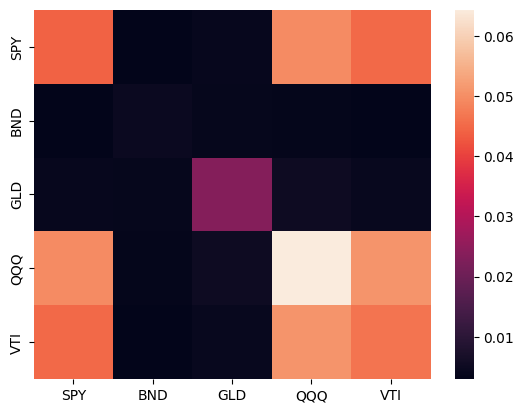

In [8]:
sns.heatmap(cov_matrix)

### Portfolio Metrics

#### 1. Portfolio Risk or Standard Deviation($\sigma$)

In [9]:
def std_dev(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

#### 2. Expected Return of the Portfolio

*Based on the assumption that the future returns are based on historical returns.*

In [10]:
def exp_returns(weights, log_returns):
    return np.sum(log_returns.mean()*weights*252) #annualized return

#### 4. Sharpe ratio 

Considers the total (systematic ($\beta$) and unsystematic) risk ($\sigma$).

$\text{Sharpe Ratio} = \frac{\text{Portfolio Return}(R_p) - \text{Risk Free Rate}(R_f)}{\sigma}$

In [11]:
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (exp_returns(weights, log_returns) - risk_free_rate) / std_dev(weights, cov_matrix)

### Retrieving the Risk Free Rate

The ten-year treasury rate obtained from FRED API is used as the risk free rate parameter in this portfolio optimization

In [12]:
from fredapi import Fred

fred = Fred(api_key='70a5960bdec357f09a4d4922e4c749d7')
ten_year_treasury_rate = fred.get_series_latest_release('GS10') / 100 #convert the whole number into percentage
risk_free_rate = ten_year_treasury_rate.iloc[-1]
print(risk_free_rate)

0.044800000000000006


### Portfolio Optimization

#### 1. Negative Sharpe Ratio

To obtain the maximum Sharpe ratio to be used by scipy.optimize.minimize() function

In [13]:
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

#### 2. Define the Constraints and Bounds

a. Constraint: The sum of the weights should be equal to 1.

b. Bound: The percentage of stock from a single ticker. It should be greater than or equal to 0 or less than 50% to minimize the imbalance.

In [14]:
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bound = [(0.1, 0.4) for _ in range(len(tickers))]
initial_weights = np.array([1/len(tickers)]*len(tickers))
print(initial_weights) # it will be 20% as there are 5 tickers in this portfolio

[0.2 0.2 0.2 0.2 0.2]


#### 3. Optimizing the Weights

To Maximize the Sharpe Ratio

SLSQP: Sequential Least Square Quadratic Programming method is used with the minimize function. It is a numerical optimization technique suitable for solving non-linear optimization problems with constraints

In [15]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method = 'SLSQP', constraints = constraints, bounds = bound)
optimized_weights = optimized_results.x

#### 4. Analyzing the Optimal Portfolio

In [16]:
print("Optimized Weights: ")
for ticker, weight in zip(tickers, optimized_weights):
    print(f'{ticker}: {weight:.4f}')

print()

optimal_portfolio_returns = exp_returns(optimized_weights, log_returns)
optimal_portfolio_volatility = std_dev(optimized_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimized_weights, log_returns, cov_matrix, risk_free_rate)

print(f'Expected Annual Return: {optimal_portfolio_returns:.4f}')
print(f'Expected Annual Volatility: {optimal_portfolio_volatility:.4f}')
print(f'Sharpe Ratio: {optimal_sharpe_ratio:.4f}')

Optimized Weights: 
SPY: 0.1000
BND: 0.1000
GLD: 0.3331
QQQ: 0.3669
VTI: 0.1000

Expected Annual Return: 0.1306
Expected Annual Volatility: 0.1515
Sharpe Ratio: 0.5660


#### 5. Visualization of Optimal Portfolio

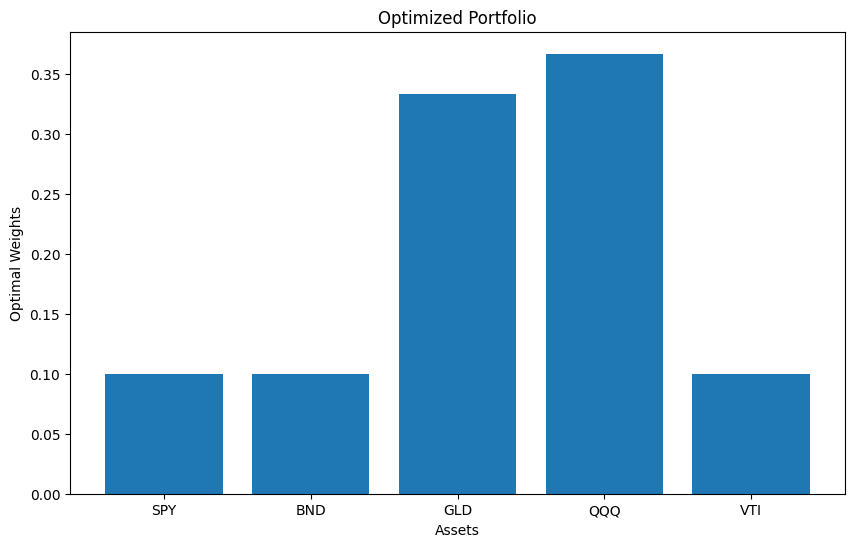

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(tickers, optimized_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimized Portfolio')
plt.show()

We have the optimized portfolio shares of stocks with S & P 500, Vanguard Total Bond Index Fund, SPDR rust, Invesco QQQ Trust, and Vanguard Total Stock Index Fund in the portfolio. The optimization gives minimum risk when the stocks are diversified between the tickers in the following way - 

| Ticker | % Allocation |
|---|---|
| SPY | 10 |
| BND | 10 |
| GLD | 33 |
| QQQ | 37 |
| VTI | 10 |

It implies that a higher investment in Gold and QQQ Trust keeps the portfolio at a lower risk and the maximum return.

From this portfolio with the current data, the following can be expected - 

Annual Return: +13.06% of investment

Annual Volatility: 15.15% chances of fluctuations in stock prices

Sharpe Ratio: 0.5660

Note: For the same portfolio, if the constraints for the bound (the minimum percentage of each stock to be present) is removed, the portfolio will be different, in this case, only two stocks will exist - GLD and QQQ. However, it is risky to invest in just two stocks, therefore, I incorporated the additional constraints!